In [113]:
!pip install kagglehub

In [114]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")

# print("Path to dataset files:", path)

<h1> Importing necessary libraries </h1>

In [115]:
import numpy as np
import matplotlib as plt
import pandas as pd

import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

<h1> Initialising Spark </h1>

In [116]:
appName = "Race Prediciton Analysis"
master = "local"

conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

sc = SparkContext.getOrCreate(conf=conf)

sqlContext = SQLContext(sc)

spark = sqlContext.sparkSession.builder.getOrCreate()

C:\spark\spark-3.5.2-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<h1> Race Performance Analysis</h1>

<h3> Datasets used: races.csv, lap_times.csv, drivers.csv, pit_stops.csv and circuits.csv</h3>
<h4> Link: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?resource=download </h4>

In [117]:
drivers = spark.read.csv("C:\\Users\\Shreya\\Desktop\\SYS TOOL\\F1\\23\\drivers.csv", header=True, inferSchema=True)
races = spark.read.csv("C:\\Users\\Shreya\\Desktop\\SYS TOOL\\F1\\23\\races.csv", header=True, inferSchema=True)
lap_times = spark.read.csv("C:\\Users\\Shreya\\Desktop\\SYS TOOL\\F1\\23\\lap_times.csv", header=True, inferSchema=True)
pit_stops = spark.read.csv("C:\\Users\\Shreya\\Desktop\\SYS TOOL\\F1\\23\\pit_stops.csv", header=True, inferSchema=True)
circuits = spark.read.csv("C:\\Users\\Shreya\\Desktop\\SYS TOOL\\F1\\23\\circuits.csv", header=True, inferSchema=True)
results = spark.read.csv("C:\\Users\\Shreya\\Desktop\\SYS TOOL\\F1\\23\\results.csv", header=True, inferSchema=True)
constructors = spark.read.csv("C:\\Users\\Shreya\\Desktop\\SYS TOOL\\F1\\23\\constructors.csv", header=True, inferSchema=True)


# dataset = spark.read.csv(["C:\\Users\\Shreya\\Desktop\\SYS TOOL\\F1\\23\\races.csv",
                        #   "C:\\Users\\Shreya\\Desktop\\SYS TOOL\\F1\\23\\lap_times.csv",
                        #   "C:\\Users\\Shreya\\Desktop\\SYS TOOL\\F1\\23\\drivers.csv",
                        #   "C:\\Users\\Shreya\\Desktop\\SYS TOOL\\F1\\23\\pit_stops.csv",
                        #   "C:\\Users\\Shreya\\Desktop\\SYS TOOL\\F1\\23\\circuits.csv"], header=True)

In [118]:
drivers.printSchema()
races.printSchema()


root
 |-- driverId: integer (nullable = true)
 |-- driverRef: string (nullable = true)
 |-- number: string (nullable = true)
 |-- code: string (nullable = true)
 |-- forename: string (nullable = true)
 |-- surname: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- nationality: string (nullable = true)
 |-- url: string (nullable = true)

root
 |-- raceId: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- round: integer (nullable = true)
 |-- circuitId: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- url: string (nullable = true)
 |-- fp1_date: string (nullable = true)
 |-- fp1_time: string (nullable = true)
 |-- fp2_date: string (nullable = true)
 |-- fp2_time: string (nullable = true)
 |-- fp3_date: string (nullable = true)
 |-- fp3_time: string (nullable = true)
 |-- quali_date: string (nullable = true)
 |-- quali_time: string (nullable = true)
 |-- sprint_date: st

In [119]:
lap_times.printSchema()

root
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- lap: integer (nullable = true)
 |-- position: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- milliseconds: integer (nullable = true)



In [120]:
pit_stops.printSchema()
circuits.printSchema()

root
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- stop: integer (nullable = true)
 |-- lap: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- duration: string (nullable = true)
 |-- milliseconds: integer (nullable = true)

root
 |-- circuitId: integer (nullable = true)
 |-- circuitRef: string (nullable = true)
 |-- name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- alt: integer (nullable = true)
 |-- url: string (nullable = true)



In [121]:
constructors.printSchema()
results.printSchema()

root
 |-- constructorId: integer (nullable = true)
 |-- constructorRef: string (nullable = true)
 |-- name: string (nullable = true)
 |-- nationality: string (nullable = true)
 |-- url: string (nullable = true)

root
 |-- resultId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- driverId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- number: string (nullable = true)
 |-- grid: integer (nullable = true)
 |-- position: string (nullable = true)
 |-- positionText: string (nullable = true)
 |-- positionOrder: integer (nullable = true)
 |-- points: double (nullable = true)
 |-- laps: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- milliseconds: string (nullable = true)
 |-- fastestLap: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- fastestLapTime: string (nullable = true)
 |-- fastestLapSpeed: string (nullable = true)
 |-- statusId: integer (nullable = true)



<H4> PHASE I: </H4>
Data Cleaning Steps: <br>
1. Renaming column names if required: <BR>
2. Correct the datatype of the columns <BR>
3. drop columns that are of no interest <br>
4. handle missing or NA values in the dataset and then drop if the null values are more than 50% <br>

In [122]:
from pyspark.sql.functions import col, sum, when

# Check for null values column-wise
# races.select([sum(col(c).isNull().cast("int")).alias(c) for c in races.columns]).show()


# races.select([sum(when(col(c) == "\\N", 1).otherwise(0)).alias(c) for c in races.columns]).show()




# Check for null, 'NA', 'N/A', or empty string values
drivers.select([sum(when(col(c).isNull() | (col(c) == "NA") | (col(c) == "\\N") | (col(c) == ""), 1)
                    .otherwise(0)).alias(c) for c in drivers.columns]).show()

races.select([sum(when(col(c).isNull() | (col(c) == "NA") | (col(c) == "\\N") | (col(c) == ""), 1)
                    .otherwise(0)).alias(c) for c in races.columns]).show()

lap_times.select([sum(when(col(c).isNull() | (col(c) == "NA") | (col(c) == "\\N") | (col(c) == ""), 1)
                    .otherwise(0)).alias(c) for c in lap_times.columns]).show()

pit_stops.select([sum(when(col(c).isNull() | (col(c) == "NA") | (col(c) == "\\N") | (col(c) == ""), 1)
                    .otherwise(0)).alias(c) for c in pit_stops.columns]).show()

circuits.select([sum(when(col(c).isNull() | (col(c) == "NA") | (col(c) == "\\N") | (col(c) == ""), 1)
                    .otherwise(0)).alias(c) for c in circuits.columns]).show()

constructors.select([sum(when(col(c).isNull() | (col(c) == "NA") | (col(c) == "\\N") | (col(c) == ""), 1)
                    .otherwise(0)).alias(c) for c in constructors.columns]).show()

results.select([sum(when(col(c).isNull() | (col(c) == "NA") | (col(c) == "\\N") | (col(c) == ""), 1)
                    .otherwise(0)).alias(c) for c in results.columns]).show()



+--------+---------+------+----+--------+-------+---+-----------+---+
|driverId|driverRef|number|code|forename|surname|dob|nationality|url|
+--------+---------+------+----+--------+-------+---+-----------+---+
|       0|        0|   802| 757|       0|      0|  0|          0|  0|
+--------+---------+------+----+--------+-------+---+-----------+---+

+------+----+-----+---------+----+----+----+---+--------+--------+--------+--------+--------+--------+----------+----------+-----------+-----------+
|raceId|year|round|circuitId|name|date|time|url|fp1_date|fp1_time|fp2_date|fp2_time|fp3_date|fp3_time|quali_date|quali_time|sprint_date|sprint_time|
+------+----+-----+---------+----+----+----+---+--------+--------+--------+--------+--------+--------+----------+----------+-----------+-----------+
|     0|   0|    0|        0|   0|   0| 731|  0|    1035|    1057|    1035|    1057|    1053|    1072|      1035|      1057|       1107|       1110|
+------+----+-----+---------+----+----+----+---+-----

So, there are no null values or NA values but /N values in there

In [123]:
# Replace 'NA', 'N/A', and empty strings with null values
drivers_cleaned = drivers.replace(["\\N"], "0")

drivers_cleaned.show(5)


races_cleaned = races.replace(["\\N"], "0")

races_cleaned.show(5)


+--------+----------+------+----+--------+----------+----------+-----------+--------------------+
|driverId| driverRef|number|code|forename|   surname|       dob|nationality|                 url|
+--------+----------+------+----+--------+----------+----------+-----------+--------------------+
|       1|  hamilton|    44| HAM|   Lewis|  Hamilton|1985-01-07|    British|http://en.wikiped...|
|       2|  heidfeld|     0| HEI|    Nick|  Heidfeld|1977-05-10|     German|http://en.wikiped...|
|       3|   rosberg|     6| ROS|    Nico|   Rosberg|1985-06-27|     German|http://en.wikiped...|
|       4|    alonso|    14| ALO|Fernando|    Alonso|1981-07-29|    Spanish|http://en.wikiped...|
|       5|kovalainen|     0| KOV|  Heikki|Kovalainen|1981-10-19|    Finnish|http://en.wikiped...|
+--------+----------+------+----+--------+----------+----------+-----------+--------------------+
only showing top 5 rows

+------+----+-----+---------+--------------------+---------+--------+--------------------+---

In [124]:
# races_cleaned.select([sum(when(col(c) == "0", 1).otherwise(0)).alias(c) for c in races_cleaned.columns]).show()

In [125]:
drivers_cleaned = drivers_cleaned.withColumn("number", col("number").cast("int"))

In [126]:
drivers_cleaned.printSchema()

root
 |-- driverId: integer (nullable = true)
 |-- driverRef: string (nullable = true)
 |-- number: integer (nullable = true)
 |-- code: string (nullable = true)
 |-- forename: string (nullable = true)
 |-- surname: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- nationality: string (nullable = true)
 |-- url: string (nullable = true)



<h1> MERGE DATASETS THAT ARE OF USE </h1>

We try here to merge the relevant datasets: results, races, contructors and drivers <br>
We see that results and race have the common column called raceId, so we join the dfs using that <br>
Later to join, contructors we see there's the common column called "constructorId" <br>

results > races > constructors > drivers

In [127]:
races = races.withColumnRenamed('name', 'gp_name')

In [128]:
df = results.join(races.select('raceId', 'year' ,'round', 'gp_name'), on='raceId', how='left')

In [129]:
print(len(df.columns))
print(df.count())

21


26519


In [130]:
# Rename a single column
constructors = constructors.withColumnRenamed('name', 'constructorName')
constructors = constructors.withColumnRenamed('nationality', 'constructorNationality')


In [131]:
df = df.join(constructors.select("constructorId", "constructorRef", "ConstructorName", "constructorNationality"), on="constructorId", how="left")

In [132]:
print(len(df.columns))
print(df.count())

24
26519


In [133]:
df.show(5)

+-------------+------+--------+--------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+----+-----+--------------------+--------------+---------------+----------------------+
|constructorId|raceId|resultId|driverId|number|grid|position|positionText|positionOrder|points|laps|       time|milliseconds|fastestLap|rank|fastestLapTime|fastestLapSpeed|statusId|year|round|             gp_name|constructorRef|ConstructorName|constructorNationality|
+-------------+------+--------+--------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+----+-----+--------------------+--------------+---------------+----------------------+
|            1|    18|       1|       1|    22|   1|       1|           1|            1|  10.0|  58|1:34:50.616|     5690616|        39|   2|      1:27.452|        218.300|       1|2008|    1|Aust

In [134]:
drivers = drivers.withColumnRenamed('nationality', 'driverNationality')

In [135]:
drivers.columns

['driverId',
 'driverRef',
 'number',
 'code',
 'forename',
 'surname',
 'dob',
 'driverNationality',
 'url']

In [136]:
df = df.join(drivers.select("driverId", "driverRef", "code", "driverNationality"), on="driverId", how="left")

In [137]:
print(len(df.columns))
print(df.count())

27


26519


In [138]:
df.show(5)

+--------+-------------+------+--------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+----+-----+--------------------+--------------+---------------+----------------------+----------+----+-----------------+
|driverId|constructorId|raceId|resultId|number|grid|position|positionText|positionOrder|points|laps|       time|milliseconds|fastestLap|rank|fastestLapTime|fastestLapSpeed|statusId|year|round|             gp_name|constructorRef|ConstructorName|constructorNationality| driverRef|code|driverNationality|
+--------+-------------+------+--------+------+----+--------+------------+-------------+------+----+-----------+------------+----------+----+--------------+---------------+--------+----+-----+--------------------+--------------+---------------+----------------------+----------+----+-----------------+
|       1|            1|    18|       1|    22|   1|       1|           1|            1|  10.0

I have the final merged dataset. Now, let's drop the irrelevant columns

In [139]:
df.select([sum(when(col(c).isNull() | (col(c) == "NA") | (col(c) == "\\N") | (col(c) == ""), 1)
                    .otherwise(0)).alias(c) for c in df.columns]).show()

+--------+-------------+------+--------+------+----+--------+------------+-------------+------+----+-----+------------+----------+-----+--------------+---------------+--------+----+-----+-------+--------------+---------------+----------------------+---------+-----+-----------------+
|driverId|constructorId|raceId|resultId|number|grid|position|positionText|positionOrder|points|laps| time|milliseconds|fastestLap| rank|fastestLapTime|fastestLapSpeed|statusId|year|round|gp_name|constructorRef|ConstructorName|constructorNationality|driverRef| code|driverNationality|
+--------+-------------+------+--------+------+----+--------+------------+-------------+------+----+-----+------------+----------+-----+--------------+---------------+--------+----+-----+-------+--------------+---------------+----------------------+---------+-----+-----------------+
|       0|            0|     0|       0|     6|   0|   10928|           0|            0|     0|   0|18986|       18986|     18499|18249|         184

In [140]:
df = df.drop("grid", "position", "positionText" ,"time", "statusId")

# Note: dropped milliseconds column because when doing analysis for 2024 dataset, the null values weere more than 50% hence dropped the column,
# anways wasn't adding any value

In [141]:
df.show(10)

+--------+-------------+------+--------+------+-------------+------+----+------------+----------+----+--------------+---------------+----+-----+--------------------+--------------+---------------+----------------------+----------+----+-----------------+
|driverId|constructorId|raceId|resultId|number|positionOrder|points|laps|milliseconds|fastestLap|rank|fastestLapTime|fastestLapSpeed|year|round|             gp_name|constructorRef|ConstructorName|constructorNationality| driverRef|code|driverNationality|
+--------+-------------+------+--------+------+-------------+------+----+------------+----------+----+--------------+---------------+----+-----+--------------------+--------------+---------------+----------------------+----------+----+-----------------+
|       1|            1|    18|       1|    22|            1|  10.0|  58|     5690616|        39|   2|      1:27.452|        218.300|2008|    1|Australian Grand ...|       mclaren|        McLaren|               British|  hamilton| HAM|   

Now that I dropped the columns, I have to sort the data accordingly!

In [142]:
df = df.orderBy(['year', 'round'], ascending=[True, True])

In [143]:
df.show(5)

+--------+-------------+------+--------+------+-------------+------+----+------------+----------+----+--------------+---------------+----+-----+------------------+--------------+---------------+----------------------+-----------+----+-----------------+
|driverId|constructorId|raceId|resultId|number|positionOrder|points|laps|milliseconds|fastestLap|rank|fastestLapTime|fastestLapSpeed|year|round|           gp_name|constructorRef|ConstructorName|constructorNationality|  driverRef|code|driverNationality|
+--------+-------------+------+--------+------+-------------+------+----+------------+----------+----+--------------+---------------+----+-----+------------------+--------------+---------------+----------------------+-----------+----+-----------------+
|     642|           51|   833|   20025|     2|            1|   9.0|  70|     8003600|        \N|  \N|            \N|             \N|1950|    1|British Grand Prix|          alfa|     Alfa Romeo|                 Swiss|     farina|  \N|       

<h2> I only want to see the data from 2024 </h2>

In [144]:
# Filter the DataFrame for rows where 'year' is 2024
df_2024 = df.filter(df['year'] == 2024)
df_2024.show(5)

print("Rows in 2024 dataset:",df.count())
print("Columns in 2024 dataset:", len(df.columns))

+--------+-------------+------+--------+------+-------------+------+----+------------+----------+----+--------------+---------------+----+-----+------------------+--------------+---------------+----------------------+--------------+----+-----------------+
|driverId|constructorId|raceId|resultId|number|positionOrder|points|laps|milliseconds|fastestLap|rank|fastestLapTime|fastestLapSpeed|year|round|           gp_name|constructorRef|ConstructorName|constructorNationality|     driverRef|code|driverNationality|
+--------+-------------+------+--------+------+-------------+------+----+------------+----------+----+--------------+---------------+----+-----+------------------+--------------+---------------+----------------------+--------------+----+-----------------+
|     830|            9|  1121|   26286|     1|            1|  26.0|  57|     5504742|        39|   1|      1:32.608|        210.383|2024|    1|Bahrain Grand Prix|      red_bull|       Red Bull|              Austrian|max_verstappen|

In [167]:
# rearrange the columns accoridngly
df_2024 = df_2024.select("round", "driverId", "raceId", "constructorId", "resultId", "positionOrder", "gp_name", 
                        "driverRef", "code", "driverNationality", "ConstructorName","constructorNationality", "constructorRef", 
                        "number", "points" ,"laps", "fastestLap", "fastestLapTime", "fastestLapSpeed","milliseconds", "rank", "year" )

In [168]:
# df_2024.show()

In [147]:
df_2024.select([sum(when(col(c).isNull() | (col(c) == "NA") | (col(c) == "\\N") | (col(c) == ""), 1)
                    .otherwise(0)).alias(c) for c in df_2024.columns]).show()

+-----+--------+------+-------------+--------+-------------+-------+---------+----+-----------------+---------------+----------------------+--------------+------+------+----+----------+--------------+---------------+------------+----+----+
|round|driverId|raceId|constructorId|resultId|positionOrder|gp_name|driverRef|code|driverNationality|ConstructorName|constructorNationality|constructorRef|number|points|laps|fastestLap|fastestLapTime|fastestLapSpeed|milliseconds|rank|year|
+-----+--------+------+-------------+--------+-------------+-------+---------+----+-----------------+---------------+----------------------+--------------+------+------+----+----------+--------------+---------------+------------+----+----+
|    0|       0|     0|            0|       0|            0|      0|        0|   0|                0|              0|                     0|             0|     0|     0|   0|        24|            24|             24|          98|   0|   0|
+-----+--------+------+-------------+---

In [148]:
df_2024 = df_2024.orderBy(['round'], ascending=[True])

In [170]:
# df_2024.select("round").distinct().count()

In [150]:
df_2024.groupBy('code').count().orderBy('count', ascending=False).show(40)
# circuits.groupBy('country').count().orderBy('count', ascending=False).show()

+----+-----+
|code|count|
+----+-----+
| OCO|   12|
| BOT|   12|
| HAM|   12|
| VER|   12|
| ZHO|   12|
| MAG|   12|
| NOR|   12|
| TSU|   12|
| HUL|   12|
| ALB|   12|
| PER|   12|
| STR|   12|
| GAS|   12|
| LEC|   12|
| RUS|   12|
| RIC|   12|
| PIA|   12|
| ALO|   12|
| SAR|   11|
| SAI|   11|
| BEA|    1|
+----+-----+



In [151]:
import seaborn as sb

In [163]:
# df_2024_round = df_2024.toPandas()
# df_2024_round["round"].hist(bins=12, color='blue')


<h2> Let's findout the number of drivers who won the grand prix 2024 season </h2>

In [153]:
winners_df = df_2024.filter(df_2024['positionOrder'] == 1)

# winners_df.show(5)
# print(len(winners_df.columns))
# print(winners_df.count())

In [166]:
x = winners_df.groupBy('driverRef').count().orderBy('count')
x = x.toPandas()
x.head()  #these are all the people who won the GRAND PRIX in the 2024 season

,driverRef,count
0,sainz,1
1,russell,1
2,hamilton,1
3,norris,1
4,leclerc,1


C:\Users\Shreya\AppData\Local\Temp\ipykernel_20392\4218359111.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=x, y='driverRef', x='count', palette='viridis')


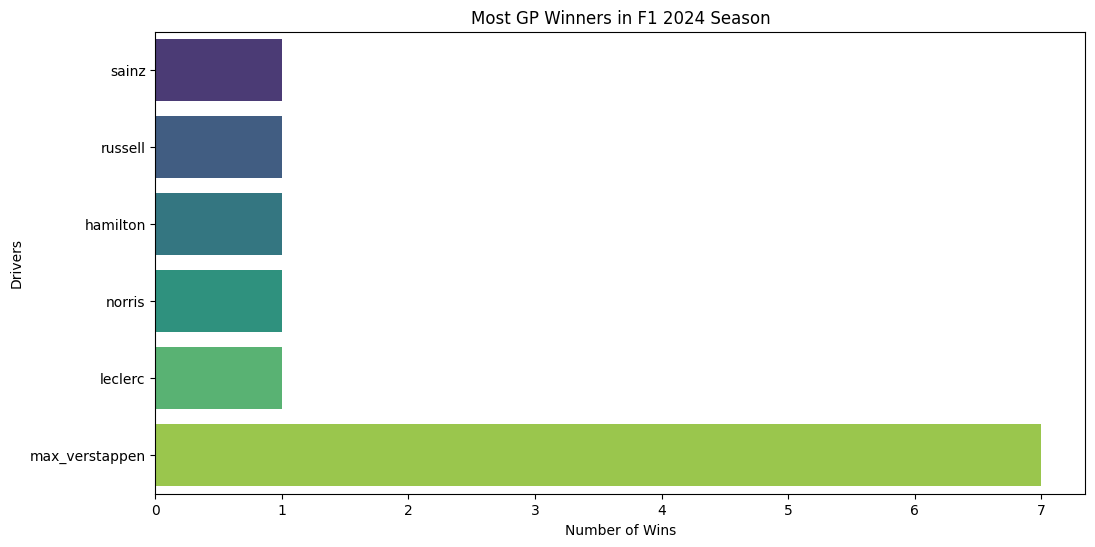

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=x, y='driverRef', x='count', palette='viridis')
plt.title('Most GP Winners in F1 2024 Season')
plt.xlabel('Number of Wins')
plt.ylabel('Drivers')
plt.show()

Fastest Lap Per Race

In [159]:
from pyspark.sql.functions import min

fastest_lap = df_2024.groupBy("raceId").agg(min("milliseconds").alias("fastestLap"))
fastest_lap.show(15)

+------+----------+
|raceId|fastestLap|
+------+----------+
|  1121|   5504742|
|  1122|   4843273|
|  1123|   4826843|
|  1124|   6863566|
|  1125|   6052554|
|  1126|   5449876|
|  1127|   5125252|
|  1128|   8595554|
|  1129|   6347927|
|  1130|   5300227|
|  1131|   5062798|
|  1132|   4947059|
+------+----------+



C:\Users\Shreya\AppData\Local\Temp\ipykernel_20392\1247835994.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fl_pd, y='fastestLap', x='raceId', palette='viridis')


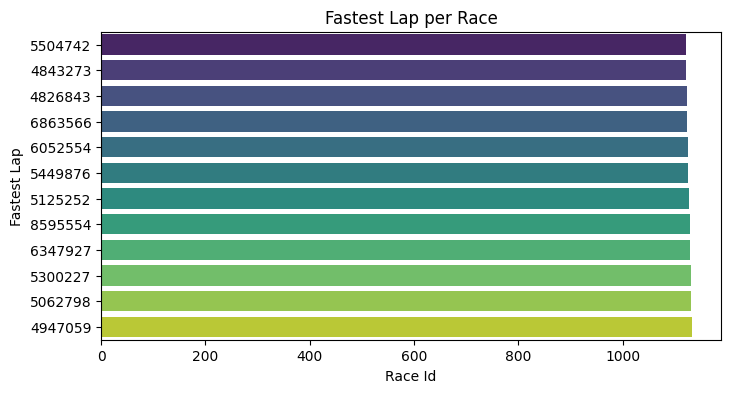

In [162]:
import matplotlib.pyplot as plt

# Convert average lap times to Pandas DataFrame
fl_pd = fastest_lap.toPandas()

# Plot average lap times
sns.barplot(data=fl_pd, y='fastestLap', x='raceId', palette='viridis')
# fl_pd.plot(kind='bar', x='raceId', y='fastestLap', legend=False)
plt.title("Fastest Lap per Race")
plt.xlabel("Race Id")
plt.ylabel("Fastest Lap")
plt.show()


Average Lap Time per Driver

In [160]:
avg_lap_times = df_2024.groupBy("driverId").agg({"milliseconds": "avg"})
avg_lap_times.show()


+--------+-----------------+
|driverId|avg(milliseconds)|
+--------+-----------------+
|     858|        5591841.5|
|     857|5773048.916666667|
|     830|5832091.909090909|
|     847|        5943905.7|
|     842|        5696275.0|
|     844|        5784310.5|
|     860|        4885952.0|
|     822|        5945323.0|
|     855|        5812049.0|
|       1|5855418.090909091|
|     852|        5456372.0|
|     839|        5697293.4|
|     846|5820312.363636363|
|     840|5534057.142857143|
|       4|       5656669.75|
|     848|        5397775.0|
|     817|5667132.666666667|
|     807|        5416652.5|
|     825|5528306.166666667|
|     832|        5793762.6|
+--------+-----------------+
only showing top 20 rows



<h1> Just playing around for now! </h1>

define the goal

In [ ]:
# df = pd.merge(results, races[['raceid', 'year', 'name', 'round']], on = 'raceId', how = 'lefT')

In [ ]:
# Merging Dataframes: Youtube Guy!


In [8]:
# display(races)

DataFrame[raceId: int, year: int, round: int, circuitId: int, name: string, date: date, time: string, url: string, fp1_date: string, fp1_time: string, fp2_date: string, fp2_time: string, fp3_date: string, fp3_time: string, quali_date: string, quali_time: string, sprint_date: string, sprint_time: string]

In [22]:
# races = races.drop("fp1_date", "fp1_time", "fp2_date", "fp2_time", "fp3_date", "fp3_time", "quali_date", "quali_time", "sprint_date", "sprint_time")

In [23]:
# races.columns

['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url']

<h3> Maybe focus on finding answers to all this questions. <br> </h3>
Driver and Team Performance: Wins, podiums, and points scored by drivers and teams each season.  <br>
Qualifying and Race Results: Positions, lap times, and consistency in both qualifying sessions and races. <br>
Championship Trends: Yearly evolution of drivers' and constructors' championships. <br>
Circuit Analysis: Fastest laps, pole positions, and wins at each circuit. <br>
Rule Changes Impact: Effects of regulation changes on team performance. <br>
Pit Stop and Strategy: Pit stop timings and strategy shifts over the years. <br>
Weather and Incidents: Effects of weather, crashes, or mechanical failures on outcomes. <br>

<h3> VISUALISING HOW MANY RACE CIRCUITS WE HAVE </h3>

In [32]:
circuits.select("country").distinct().show()

+-------------+
|      country|
+-------------+
|       Russia|
|       Sweden|
|     Malaysia|
|    Singapore|
|       Turkey|
|      Germany|
|       France|
|    Argentina|
|      Belgium|
|        Qatar|
|        China|
|United States|
|        India|
|        Italy|
|        Spain|
|       Monaco|
|      Morocco|
|          USA|
|       Mexico|
|   Azerbaijan|
+-------------+
only showing top 20 rows



In [173]:
circuits.groupBy('country').count().orderBy('count', ascending=False).show(40)

+-------------+-----+
|      country|count|
+-------------+-----+
|          USA|   11|
|       France|    7|
|        Spain|    6|
|        Italy|    4|
|           UK|    4|
|     Portugal|    4|
|      Germany|    3|
|      Belgium|    3|
|       Canada|    3|
|        Japan|    3|
|       Brazil|    2|
|    Australia|    2|
|      Austria|    2|
| South Africa|    2|
|       Russia|    1|
|       Sweden|    1|
|     Malaysia|    1|
|    Singapore|    1|
|       Turkey|    1|
|    Argentina|    1|
|        Qatar|    1|
|        China|    1|
|United States|    1|
|        India|    1|
|       Monaco|    1|
|      Morocco|    1|
|       Mexico|    1|
|   Azerbaijan|    1|
| Saudi Arabia|    1|
|          UAE|    1|
|  Switzerland|    1|
|        Korea|    1|
|      Bahrain|    1|
|      Hungary|    1|
|  Netherlands|    1|
+-------------+-----+



<h3> VISUALISING HOW MANY RACES WERE HELD EACH YEAR </h3>

In [43]:
races.select("year").distinct().count()

75

In [63]:
races.groupBy('year').count().orderBy('year', ascending=True).show()

+----+-----+
|year|count|
+----+-----+
|1950|    7|
|1951|    8|
|1952|    8|
|1953|    9|
|1954|    9|
|1955|    7|
|1956|    8|
|1957|    8|
|1958|   11|
|1959|    9|
|1960|   10|
|1961|    8|
|1962|    9|
|1963|   10|
|1964|   10|
|1965|   10|
|1966|    9|
|1967|   11|
|1968|   12|
|1969|   11|
+----+-----+
only showing top 20 rows



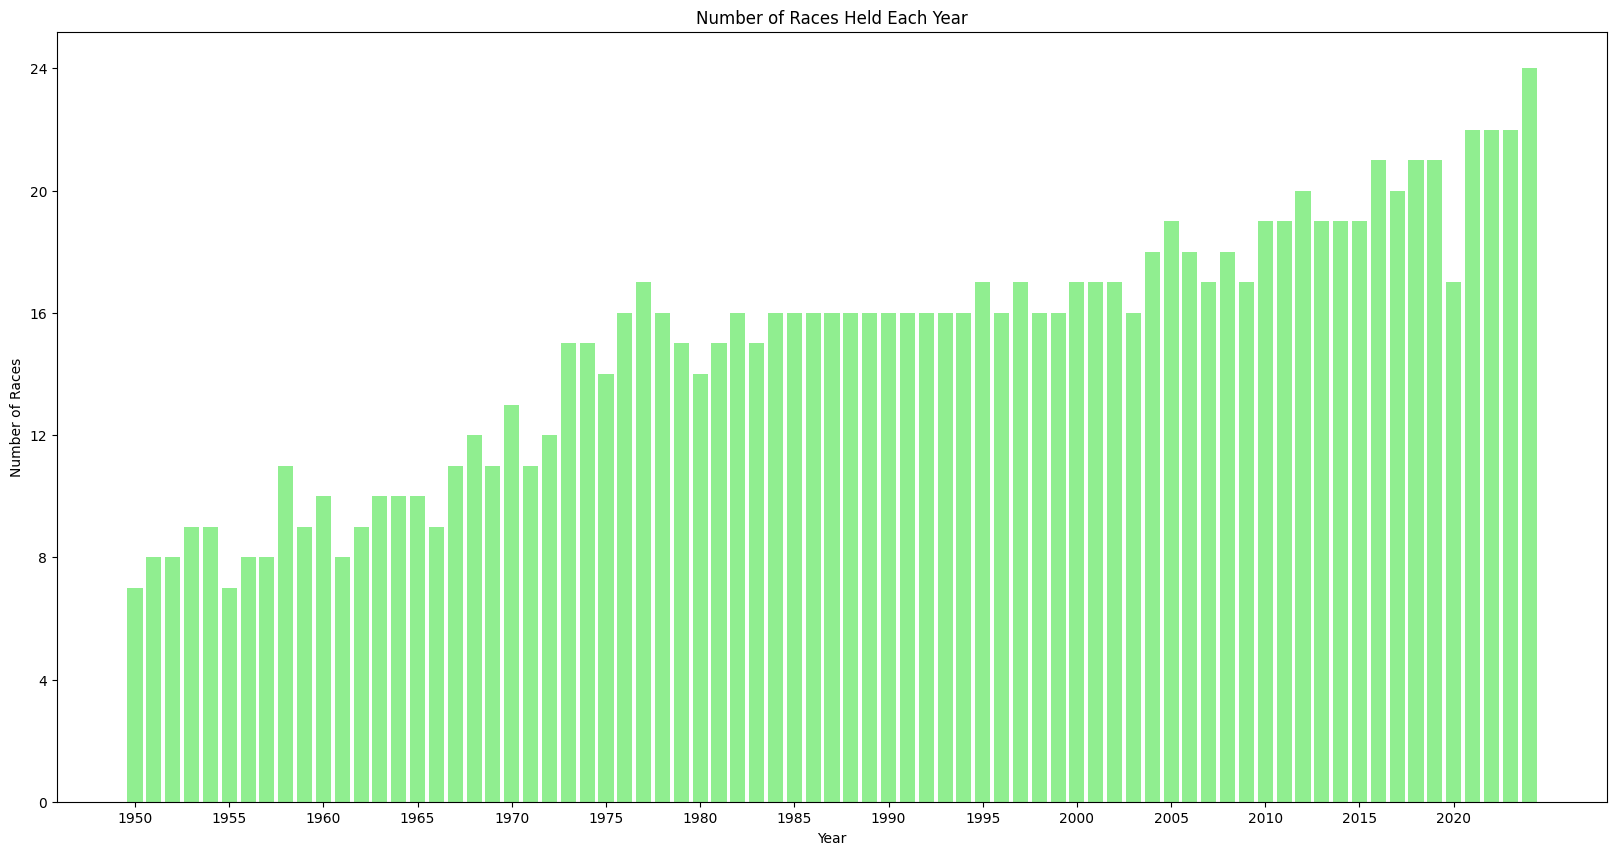

In [91]:
import matplotlib.pyplot as plt

# Step 1: Group by 'year' and count the races
race_counts = races.groupBy('year').count().orderBy('year')

# Step 2: Convert to Pandas DataFrame for visualization
race_counts_pd = race_counts.toPandas()

# Step 3: Plot the results
plt.figure(figsize=(20, 10))
plt.bar(race_counts_pd['year'], race_counts_pd['count'], color='lightgreen')
plt.xlabel('Year')
plt.ylabel('Number of Races')
plt.title('Number of Races Held Each Year')
plt.yticks(np.arange(0, 25, step=4))
plt.xticks(np.arange(1950, 2024, step=5))
plt.show()
# 

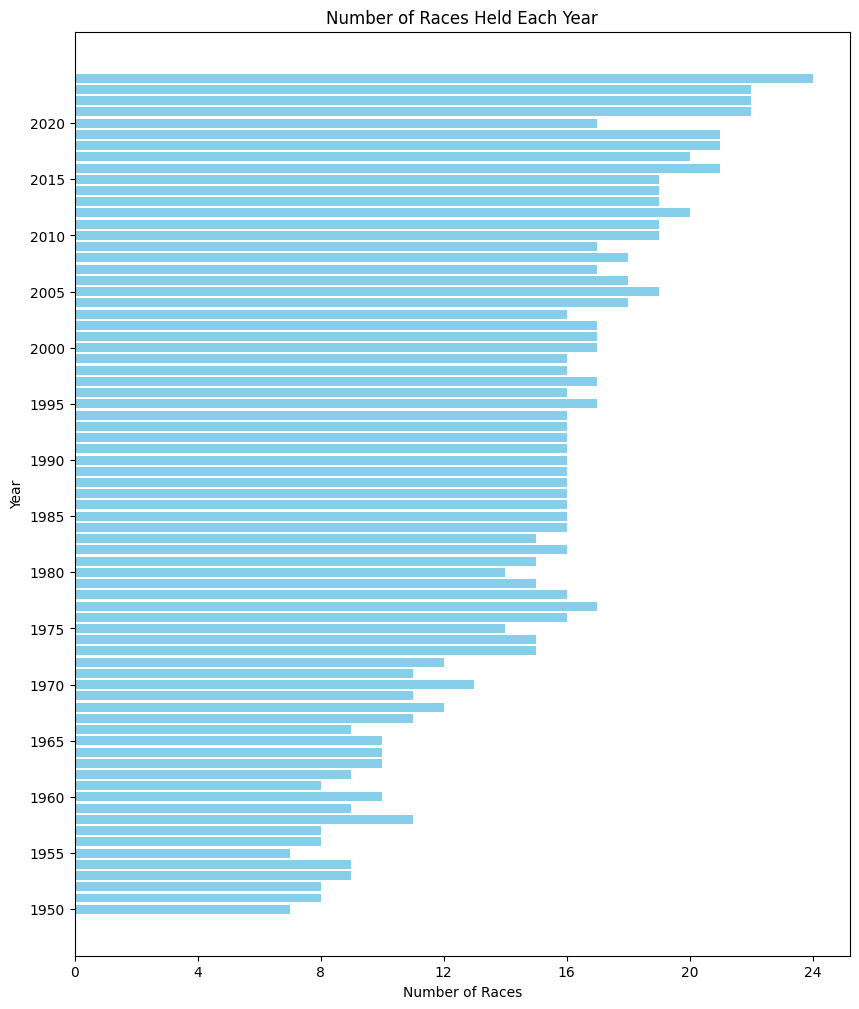

In [97]:
plt.figure(figsize=(10, 12))
plt.barh(race_counts_pd['year'], race_counts_pd['count'], color='skyblue')
plt.xlabel('Number of Races')
plt.ylabel('Year')
plt.title('Number of Races Held Each Year')
plt.xticks(np.arange(0, 25, step=4))
plt.yticks(np.arange(1950, 2024, step=5))
plt.show()

In [81]:
# another way of plotting how many races have been held each year
# Here I have kept the number of bins to be 75 since I know how many years are there in the dataset from 1950 - 2024.
# races_pd = races.toPandas()

# races_pd["year"].hist(bins=75, color='blue')

I wanted to sort the race file according to the year and round and since, date and time are of no relevance I dropped it with the url <br>
ANother way of sorting it could also be with circuit Id <br>
Another thing that can be done here is we can observe only a particular year's data <br>
Alos notice, when we sorted it by year and round, the race Id has been mixed up

In [101]:
# Sort the races DataFrame by 'year' and 'round'
races_sorted = races.orderBy(['year', 'round'], ascending=[True, True])

races_sorted = races_sorted.drop("date", "time", "url")
races_sorted.show(20)

+------+----+-----+---------+------------------+
|raceId|year|round|circuitId|              name|
+------+----+-----+---------+------------------+
|   833|1950|    1|        9|British Grand Prix|
|   834|1950|    2|        6| Monaco Grand Prix|
|   835|1950|    3|       19|  Indianapolis 500|
|   836|1950|    4|       66|  Swiss Grand Prix|
|   837|1950|    5|       13|Belgian Grand Prix|
|   838|1950|    6|       55| French Grand Prix|
|   839|1950|    7|       14|Italian Grand Prix|
|   825|1951|    1|       66|  Swiss Grand Prix|
|   826|1951|    2|       19|  Indianapolis 500|
|   827|1951|    3|       13|Belgian Grand Prix|
|   828|1951|    4|       55| French Grand Prix|
|   829|1951|    5|        9|British Grand Prix|
|   830|1951|    6|       20| German Grand Prix|
|   831|1951|    7|       14|Italian Grand Prix|
|   832|1951|    8|       67|Spanish Grand Prix|
|   817|1952|    1|       66|  Swiss Grand Prix|
|   818|1952|    2|       19|  Indianapolis 500|
|   819|1952|    3| 